In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests
import zipfile
import geopandas as gpd
import urllib3

# Extracting data from [US Environmental Protection Agency](https://aqs.epa.gov/aqsweb/airdata/download_files.html)

The following code downloads every single `.zip` file from the Annual Summary Data table, specifically the AQI by County column. Then the `.csv` files are extracted and concatenated into a single pandas dataframe. The resulting dataframe, `final_df` is converted into `combined_aqi_by_county.csv` and saved to drive.

Getting the file from Drive is faster than doing this entire process everytime a new runtime connection has to be made.

(Last run: May 7th, 2025)

```
import os
import zipfile
import shutil

# Create directories for zipped and extracted data if they don't exist
os.makedirs('/content/zipped', exist_ok=True)
os.makedirs('/content/extracted_data', exist_ok=True)

# Download all ZIP files for 2024 to 1980 into the 'zipped' folder
base_url = 'https://aqs.epa.gov/aqsweb/airdata/annual_aqi_by_county_{}.zip'

for year in range(2024, 1979, -1):  # Download files from 2024 to 1980
    zip_file_name = os.path.join('/content/zipped', f'annual_aqi_by_county_{year}.zip')  # Save as annual_aqi_by_county_YEAR.zip
    download_url = base_url.format(year)
    print(f"Downloading {download_url}...")
    !wget -O {zip_file_name} {download_url}

# Unzip each downloaded file into 'extracted_data'
for zip_file in os.listdir('/content/zipped'):
    zip_file_path = os.path.join('/content/zipped', zip_file)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/extracted_data')

# Delete the 'zipped' folder and its contents after extraction
shutil.rmtree('/content/zipped')
shutil.rmtree('/content/sample_data')

# Verify extraction
!ls /content/extracted_data

# Initialize an empty list to hold individual DataFrames
df_list = []

# Read all CSV files from the extracted data and combine them into a single DataFrame
for file in os.listdir('/content/extracted_data'):
    if file.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join('/content/extracted_data', file)
        print(f"Reading {file_path}...")
        df = pd.read_csv(file_path)  # Read each CSV file into a DataFrame
        df_list.append(df)  # Add the DataFrame to the list

# Concatenate all DataFrames into a single DataFrame
final_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined DataFrame
final_df.head()

# Save the DataFrame to a CSV file
final_df.to_csv('/content/combined_aqi_by_county.csv', index=False)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path inside your Google Drive
output_path = '/content/drive/My Drive/Colab Notebooks/Datasets, spreadsheets, etc.'

# Create the folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Save the DataFrame to that path
final_df.to_csv(f'{output_path}/combined_aqi_by_county.csv', index=False)

## (Optional) Download the CSV file
# from google.colab import files
# files.download('/content/combined_aqi_by_county.csv')
```

# Getting the data

In [2]:
# Easy simple way of accessing my datasets
if 'aqi_df' not in globals(): # simple if statement to not download again the data when I click 'run all'
    raw_df_sharelink = 'https://drive.google.com/file/d/130DVMpCfi1dujuygMyI8bzoP1fvSONvO/view?usp=drive_link' # this is the link received when clicked the Share button in Google Drive
    raw_df = pd.read_csv('https://drive.google.com/uc?export=download&id='+raw_df_sharelink.split('/d/')[1].split('/')[0]) # this parses the string from the line above to make a download link

aqi_df = raw_df.copy() # maintaining a raw_df in case I do any changes to the base dataframe by mistake, this makes it so it resets everytime I run all

# Preparing the data

In [3]:
print(aqi_df['State'].unique())

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Canada' 'Colorado'
 'Connecticut' 'Country Of Mexico' 'Delaware' 'District Of Columbia'
 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan'
 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada'
 'New Hampshire' 'New Jersey' 'New Mexico' 'New York' 'North Carolina'
 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virgin Islands' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin' 'Wyoming' 'Guam']


In [4]:
# Remove a few states I don't want to analyse, some aren't even US states..
aqi_df = aqi_df[~aqi_df['State'].isin(['Canada', 'Country Of Mexico', 'Alaska', 'Hawaii', 'District Of Columbia', 'Puerto Rico', 'Virgin Islands', 'Guam'])].copy()
print(aqi_df['State'].unique())

['Alabama' 'Arizona' 'Arkansas' 'California' 'Colorado' 'Connecticut'
 'Delaware' 'Florida' 'Georgia' 'Idaho' 'Illinois' 'Indiana' 'Iowa'
 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland' 'Massachusetts'
 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska'
 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [5]:
# Add a column with state abbreviations

state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

aqi_df['State Abbrev'] = aqi_df['State'].map(state_abbrev)
aqi_df

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,State Abbrev
0,Alabama,Baldwin,2001,283,174,95,12,2,0,0,159,84,46,0,0,203,80,0,AL
1,Alabama,Clay,2001,279,145,119,14,1,0,0,164,87,49,0,0,197,82,0,AL
2,Alabama,Colbert,2001,100,36,64,0,0,0,0,90,78,55,0,0,0,100,0,AL
3,Alabama,DeKalb,2001,365,198,136,28,3,0,0,164,97,47,0,0,292,73,0,AL
4,Alabama,Elmore,2001,241,165,63,12,1,0,0,154,80,43,0,0,241,0,0,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41531,Wyoming,Laramie,1988,54,53,1,0,0,0,0,52,26,16,0,0,0,0,54,WY
41532,Wyoming,Park,1988,51,39,12,0,0,0,0,98,61,28,0,0,0,0,51,WY
41533,Wyoming,Sheridan,1988,278,206,70,2,0,0,0,115,62,38,0,0,0,0,278,WY
41534,Wyoming,Sublette,1988,70,70,0,0,0,0,0,43,32,15,0,0,0,70,0,WY


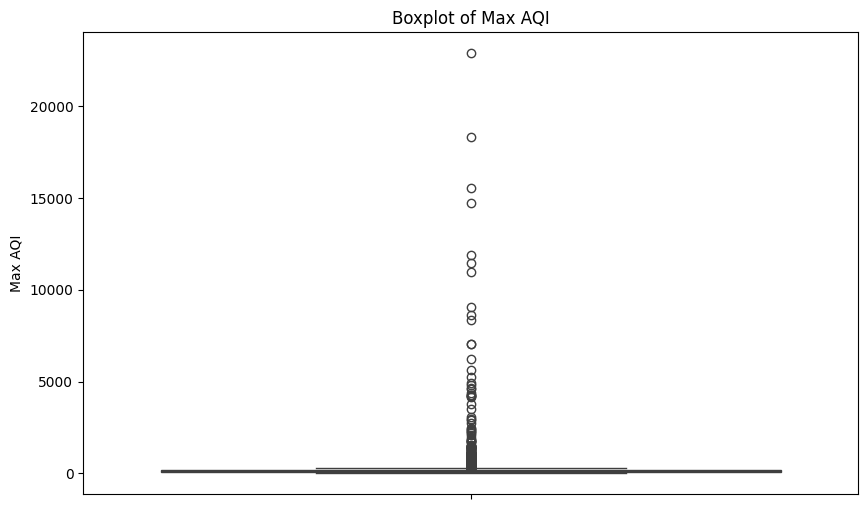

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=aqi_df['Max AQI'])
plt.title('Boxplot of Max AQI')
plt.ylabel('Max AQI')
plt.show()

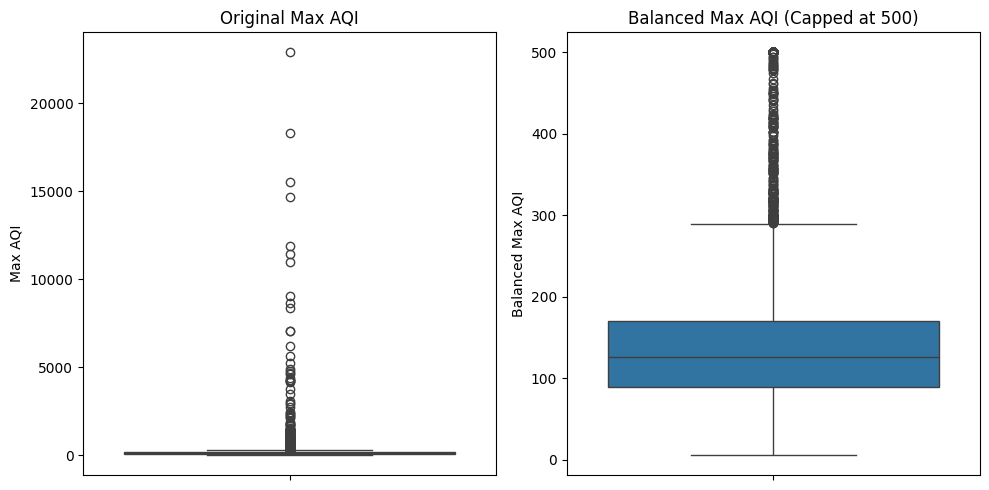

In [7]:
# Let's replace those high values, probably errors with the max accepted value of 500
aqi_df['Balanced Max AQI'] = aqi_df['Max AQI'].apply(lambda x: 500 if x > 500 else x)

# Let's reevaluate the boxplot
fig_maxaqi, axes_maxaqi = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(y=aqi_df['Max AQI'], ax=axes_maxaqi[0])
axes_maxaqi[0].set_title("Original Max AQI")
sns.boxplot(y=aqi_df['Balanced Max AQI'], ax=axes_maxaqi[1])
axes_maxaqi[1].set_title("Balanced Max AQI (Capped at 500)")
plt.tight_layout()
plt.show()

# Analyzing the data

| **Column**                              | **Description**                                                                                                                                                                                    |
| --------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Days with AQI**                       | Total number of days in the year for which the Air Quality Index (AQI) was calculated.                                                                                                             |
| **Good Days**                           | Number of days the AQI was in the "Good" range (0–50), meaning air quality was satisfactory with little or no risk.                                                                                |
| **Moderate Days**                       | Number of days the AQI was in the "Moderate" range (51–100), which may pose a minor risk to a very small number of sensitive individuals.                                                          |
| **Unhealthy for Sensitive Groups Days** | Days when AQI was in the 101–150 range, where sensitive individuals (e.g., elderly, children, those with asthma) may experience health effects, but the general public is unlikely to be affected. |
| **Unhealthy Days**                      | Days with AQI in the 151–200 range. Everyone may begin to experience health effects, and members of sensitive groups may experience more serious effects.                                          |
| **Very Unhealthy Days**                 | Days with AQI between 201–300. Health alert: everyone may experience more serious health effects.                                                                                                  |
| **Hazardous Days**                      | Days with AQI above 300. Health warnings of emergency conditions: the entire population is more likely to be affected.                                                                             |
| **Max AQI**                             | The highest (worst) AQI value recorded for the county during the year.                                                                                                                             |
| **90th Percentile AQI**                 | The AQI value below which 90% of the daily AQI values fall. This gives an idea of how bad AQI gets on the worse days, without considering extremes.                                                |
| **Median AQI**                          | The middle AQI value for the year—half of the AQI values were above this, and half were below.                                                                                                     |
| **Days CO**                             | Number of days where carbon monoxide (CO) was the primary pollutant determining the AQI.                                                                                                           |
| **Days NO2**                            | Number of days where nitrogen dioxide (NO₂) was the primary pollutant determining the AQI.                                                                                                         |
| **Days Ozone**                          | Number of days where ground-level ozone was the dominant pollutant affecting the AQI.                                                                                                              |
| **Days PM2.5**                          | Number of days where fine particulate matter (PM2.5) was the primary pollutant.                                                                                                                    |
| **Days PM10**                           | Number of days where coarse particulate matter (PM10) was the primary pollutant.                                                                                                                   |


In [8]:
aqi_df.columns

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10', 'State Abbrev',
       'Balanced Max AQI'],
      dtype='object')

## Max and Median AQIs

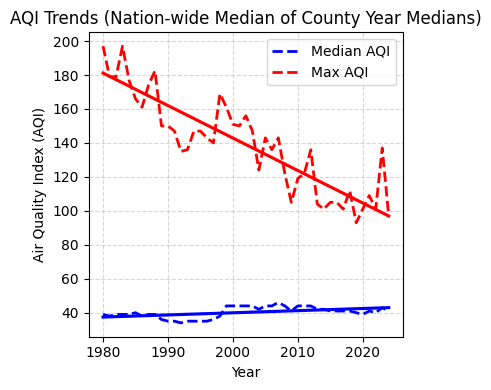

In [9]:
## Trendlines of Max AQI and Median AQI over the entire timespace

USAQI_median_byyears = aqi_df.groupby('Year')[['Median AQI', 'Max AQI']].median(numeric_only=True).reset_index()

# Reshape the data, this isn't necessary but it is good practice because of the way seaborn handles lineplots. Basically this merges the columns ['Median AQI', 'Max AQI'] into one column ['Type'] where the value is either 'Median AQI' or 'Max AQI'
USAQI_byyears_melted = USAQI_median_byyears.melt(id_vars='Year', value_vars=['Median AQI', 'Max AQI'], var_name='Type', value_name='AQI')

plt.figure(figsize=(4, 4))

# Median AQI
subset_median_medianAQI = USAQI_byyears_melted[USAQI_byyears_melted['Type'] == 'Median AQI']
sns.regplot(data=subset_median_medianAQI, x='Year', y='AQI', scatter=False, color='blue', line_kws={'label': 'Trend (Median AQI)'}, ci=None)
plt.plot(subset_median_medianAQI['Year'], subset_median_medianAQI['AQI'], color='blue', label='Median AQI', linewidth=2, linestyle='--')

# Max AQI
subset_median_maxAQI = USAQI_byyears_melted[USAQI_byyears_melted['Type'] == 'Max AQI']
sns.regplot(data=subset_median_maxAQI, x='Year', y='AQI', scatter=False, color='red', line_kws={'label': 'Trend (Max AQI)'}, ci=None)
plt.plot(subset_median_maxAQI['Year'], subset_median_maxAQI['AQI'], color='red', label='Max AQI', linewidth=2, linestyle='--')

# Title and labels
plt.title('AQI Trends (Nation-wide Median of County Year Medians)')
plt.xlabel('Year')
plt.ylabel('Air Quality Index (AQI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Average of Days per Category by Year

In [10]:
## - getting a row with hazardous days and a smaller value of days with AQI to serve as example in the README.md
# aqi_df[((aqi_df['Hazardous Days'] + 100) >= aqi_df['Days with AQI']) & (aqi_df['Hazardous Days'] >= 1)]

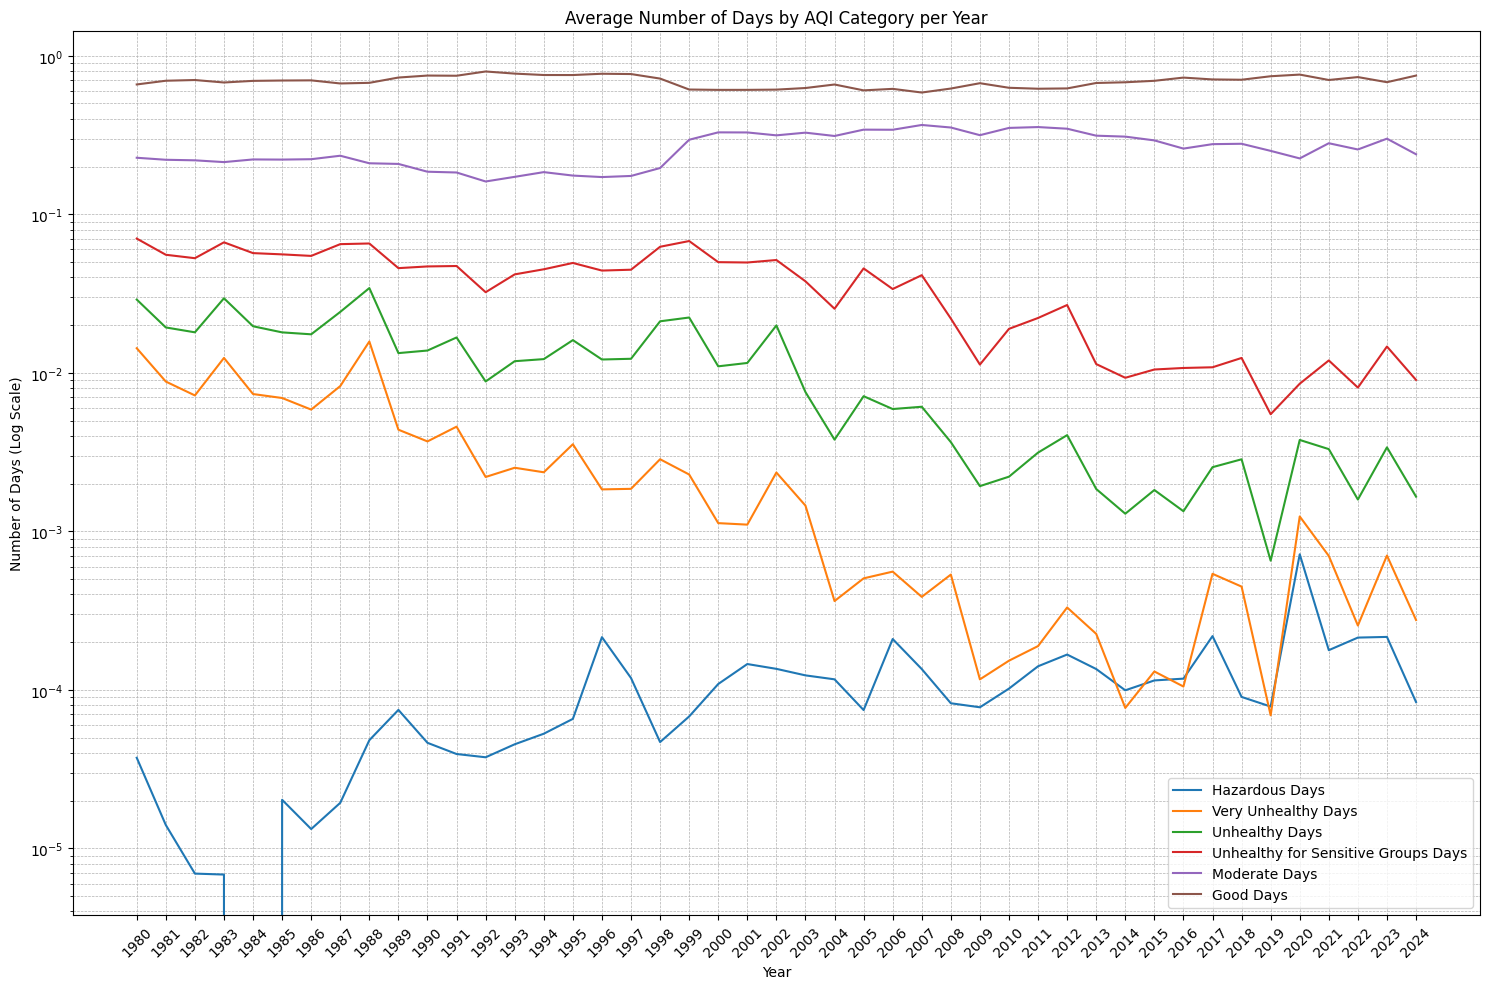

In [11]:
# Group by State and Year, calculate per-year proportions
yearly = aqi_df.groupby(['Year']).apply(
    lambda x: pd.Series({
        'Yearly Good Proportion': x['Good Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Moderate Proportion': x['Moderate Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Unhealthy for Sensitive Groups Proportion': x['Unhealthy for Sensitive Groups Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Unhealthy Proportion': x['Unhealthy Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Very Unhealthy Proportion': x['Very Unhealthy Days'].sum() / x['Days with AQI'].sum(),
        'Yearly Hazardous Proportion': x['Hazardous Days'].sum() / x['Days with AQI'].sum(),
        'Total Days with AQI': x['Days with AQI'].sum()  # Optional, useful for reference
    }),
    include_groups=False
).reset_index()

avg_days_byyear = yearly.groupby('Year').mean(numeric_only=True).reset_index()
avg_days_byyear.head()

# Create the plot
plt.figure(figsize=(15, 10))

plt.plot(avg_days_byyear['Year'], avg_days_byyear['Yearly Hazardous Proportion'], label='Hazardous Days')
plt.plot(avg_days_byyear['Year'], avg_days_byyear['Yearly Very Unhealthy Proportion'], label='Very Unhealthy Days')
plt.plot(avg_days_byyear['Year'], avg_days_byyear['Yearly Unhealthy Proportion'], label='Unhealthy Days')
plt.plot(avg_days_byyear['Year'], avg_days_byyear['Yearly Unhealthy for Sensitive Groups Proportion'], label='Unhealthy for Sensitive Groups Days')
plt.plot(avg_days_byyear['Year'], avg_days_byyear['Yearly Moderate Proportion'], label='Moderate Days')
plt.plot(avg_days_byyear['Year'], avg_days_byyear['Yearly Good Proportion'], label='Good Days')

plt.yscale('log')  # for better visualization
plt.xlabel('Year')
plt.ylabel('Number of Days (Log Scale)')
plt.title('Average Number of Days by AQI Category per Year')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(avg_days_byyear['Year'], rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# no hazardous days in 1984??

aqi_df[aqi_df['Year'] == 1984].sort_values(by='Max AQI', ascending=False).head(5)

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,State Abbrev,Balanced Max AQI
30119,California,Los Angeles,1984,366,5,71,101,52,137,0,300,263,154,70,87,209,0,0,CA,300
30130,California,San Bernardino,1984,366,19,122,48,40,137,0,300,268,136,0,133,233,0,0,CA,300
30127,California,Riverside,1984,366,52,116,40,52,106,0,300,243,110,29,105,232,0,0,CA,300
30449,Pennsylvania,Blair,1984,363,310,39,12,1,1,0,284,61,34,13,153,197,0,0,PA,284
30471,Rhode Island,Kent,1984,300,198,51,24,15,12,0,281,143,42,0,0,300,0,0,RI,281


## Which is the worst/best state?

Shapefile not found — downloading and extracting...
Download and extraction complete.

This takes the median of each county and gets the average of them, for all time period.



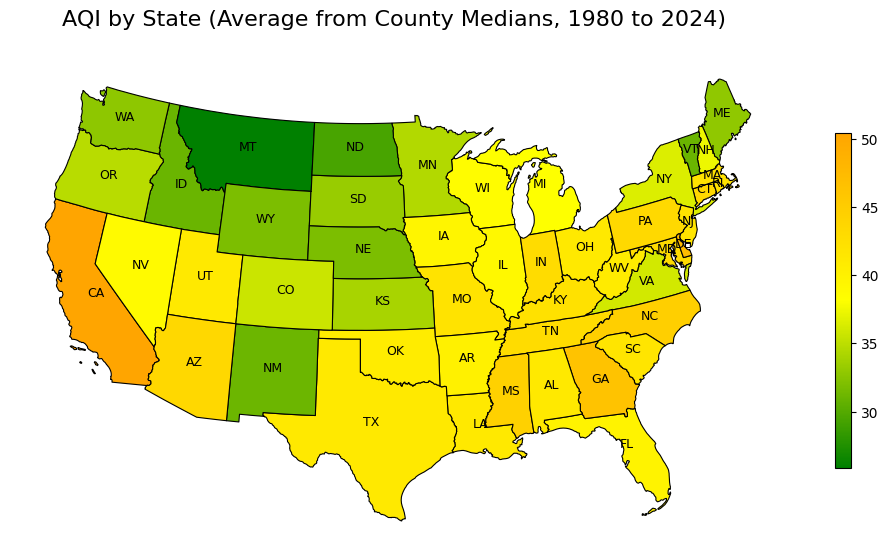

In [13]:
# Define URLs and paths
url = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip'
zip_path = '/content/USshape_zipped/cb_2021_us_state_20m.zip'
extract_path = '/content/USshape_extracted/'
shapefile_path = os.path.join(extract_path, 'cb_2021_us_state_20m.shp')

# Check if shapefile already exists
if not os.path.exists(shapefile_path):
    print("Shapefile not found — downloading and extracting...")

    # Create directories if they don't exist
    os.makedirs(os.path.dirname(zip_path), exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)

    # Disable SSL warnings and download ZIP file
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    response = requests.get(url, verify=False)
    with open(zip_path, 'wb') as f:
        f.write(response.content)

    # Extract contents
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("Download and extraction complete.\n")
else:
    print("Shapefile already exists — skipping download.\n")

# Load shapefile
states = gpd.read_file(shapefile_path)

# Data prep
Alltime_avg_state = aqi_df.groupby('State Abbrev')['Median AQI'].mean().reset_index()

# Drop unwanted regions (e.g., Puerto Rico, DC)
states = states[~states['NAME'].isin(['Canada', 'Country Of Mexico', 'Alaska', 'Hawaii', 'District Of Columbia', 'District of Columbia', 'Puerto Rico', 'Virgin Islands', 'Guam'])]
states = states.rename(columns={'STUSPS': 'State Abbrev'})

# Merge the GeoDataFrame with AQI data
aqi_map = states.merge(Alltime_avg_state, on='State Abbrev')

# this tilts the map
aqi_map = aqi_map.to_crs(epsg=2163)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Choropleth colored by Median AQI
import matplotlib.colors as mcolors
colors = ["green", "yellow", "orange"]
cmap = mcolors.LinearSegmentedColormap.from_list("GreenYellowOrange", colors)
aqi_map.plot(
    column='Median AQI',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0',
    legend=True,
    legend_kwds={'label': "", 'shrink': 0.5}
)

# Add state abbreviation labels on centroids
for idx, row in aqi_map.iterrows():
    plt.annotate(
        text=row['State Abbrev'],
        xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
        ha='center',
        fontsize=9,
        color='black'
    )

ax.set_title("AQI by State (Average from County Medians, 1980 to 2024) \n", fontsize=16)
ax.axis('off')
plt.tight_layout()
print("This takes the median of each county and gets the average of them, for all time period.\n")
plt.show()

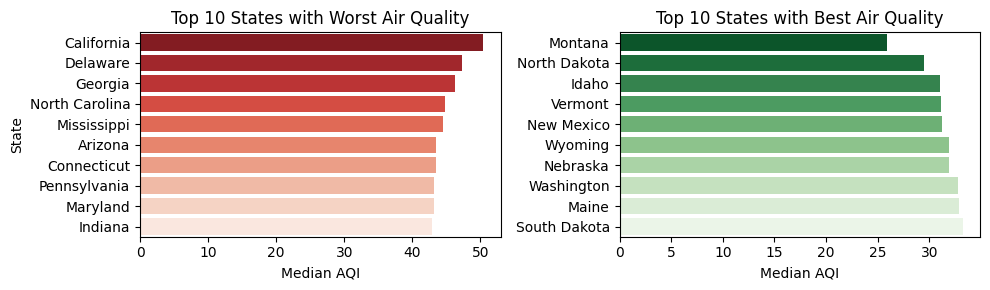

In [14]:
## Check top 10 states with worse and best AIR Quality. This assumes same level of wieght to every measurement, for all counties and all time

# Group by states, aggregates all years all counties
USAQI_mean_bystates = aqi_df.groupby("State")[["Median AQI", "Max AQI"]].mean().reset_index()

# Ranking of best states
best_states = USAQI_mean_bystates.sort_values(by="Median AQI", ascending=True)

# Ranking of worst states
worst_states = USAQI_mean_bystates.sort_values(by="Median AQI", ascending=False)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharex=False)

# Worst 10 states
sns.barplot(data=worst_states.head(10), x="Median AQI", y="State", hue="State", palette="Reds_r", legend=False, ax=axes[0])
axes[0].set_title("Top 10 States with Worst Air Quality")
axes[0].set_xlabel("Median AQI")
axes[1].set_ylabel("")

# Best 10 states
reversed_palette = sns.color_palette("Greens", n_colors=10)[::-1] # reverse the colors of best states to emphasize Montana over South Dakota
sns.barplot(data=best_states.head(10), x="Median AQI", y="State", hue="State", palette=reversed_palette, legend=False, ax=axes[1])
axes[1].set_title("Top 10 States with Best Air Quality")
axes[1].set_xlabel("Median AQI")
axes[1].set_ylabel("")

# Adjust layout
plt.tight_layout()
plt.show()

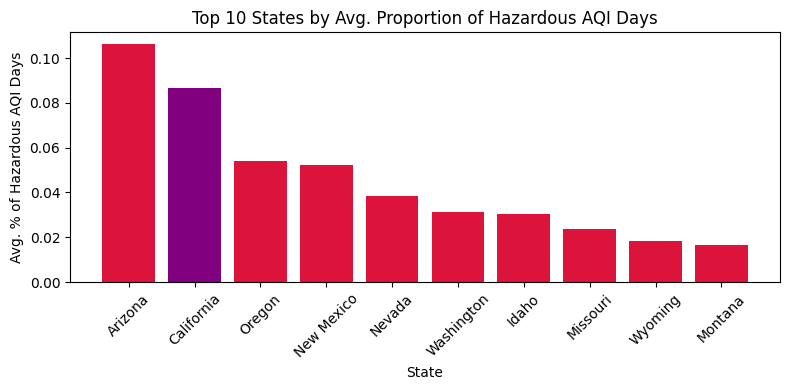

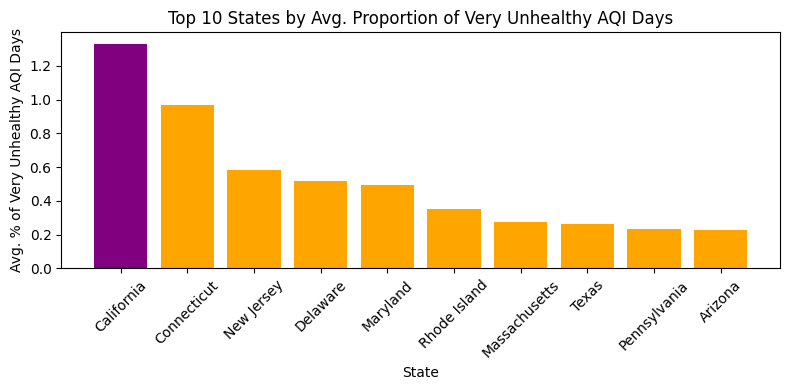

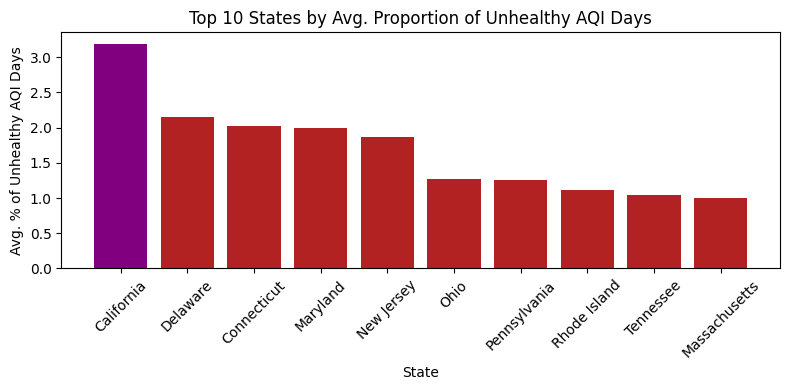

In [15]:
state_avg = aqi_df.groupby('State').apply(
    lambda x: pd.Series({
        'Good Proportion': x['Good Days'].sum() / x['Days with AQI'].sum(),
        'Moderate Proportion': x['Moderate Days'].sum() / x['Days with AQI'].sum(),
        'Unhealthy for Sensitive Groups Proportion': x['Unhealthy for Sensitive Groups Days'].sum() / x['Days with AQI'].sum(),
        'Unhealthy Proportion': x['Unhealthy Days'].sum() / x['Days with AQI'].sum(),
        'Very Unhealthy Proportion': x['Very Unhealthy Days'].sum() / x['Days with AQI'].sum(),
        'Hazardous Proportion': x['Hazardous Days'].sum() / x['Days with AQI'].sum(),
        'Total Days with AQI': x['Days with AQI'].sum()  # Optional, useful for reference
    }),
    include_groups=False
).reset_index()

# Plot top 10 states by average yearly hazardous proportion
top10_hazardous = state_avg.sort_values(by='Hazardous Proportion', ascending=False).head(10)

plt.figure(figsize=(8, 4))
colors = ['purple' if state == 'California' else 'crimson' for state in top10_hazardous['State']]
plt.bar(top10_hazardous['State'], top10_hazardous['Hazardous Proportion'] * 100, color=colors)
plt.xlabel('State')
plt.ylabel('Avg. % of Hazardous AQI Days')
plt.title('Top 10 States by Avg. Proportion of Hazardous AQI Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot top 10 states by average yearly Very Unhealthy proportion
top10_unhealthy = state_avg.sort_values(by='Very Unhealthy Proportion', ascending=False).head(10)

plt.figure(figsize=(8, 4))
colors = ['purple' if state == 'California' else 'orange' for state in top10_unhealthy['State']]
plt.bar(top10_unhealthy['State'], top10_unhealthy['Very Unhealthy Proportion'] * 100, color=colors)
plt.xlabel('State')
plt.ylabel('Avg. % of Very Unhealthy AQI Days')
plt.title('Top 10 States by Avg. Proportion of Very Unhealthy AQI Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot top 10 states by average yearly Unhealthy proportion
top10_unhealthy = state_avg.sort_values(by='Unhealthy Proportion', ascending=False).head(10)

plt.figure(figsize=(8, 4))
colors = ['purple' if state == 'California' else 'firebrick' for state in top10_unhealthy['State']]
plt.bar(top10_unhealthy['State'], top10_unhealthy['Unhealthy Proportion'] * 100, color=colors)
plt.xlabel('State')
plt.ylabel('Avg. % of Unhealthy AQI Days')
plt.title('Top 10 States by Avg. Proportion of Unhealthy AQI Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## The California Situation

In [16]:
aqi_df[aqi_df['State'] == 'California']['County'].unique()

array(['Alameda', 'Amador', 'Butte', 'Calaveras', 'Colusa',
       'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn',
       'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen',
       'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino',
       'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange',
       'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito',
       'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin',
       'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara',
       'Santa Cruz', 'Shasta', 'Siskiyou', 'Solano', 'Sonoma',
       'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne',
       'Ventura', 'Yolo', 'Sierra', 'Alpine', 'Yuba'], dtype=object)

In [17]:
# Filter for California and compute median AQI per year
ca_aqi = aqi_df[aqi_df['State'] == 'California']
ca_aqi.drop('State', axis=1)

,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,State Abbrev,Balanced Max AQI
63,Alameda,2001,365,269,78,12,6,0,0,187,72,41,1,120,168,76,0,CA,187
64,Amador,2001,365,250,89,25,1,0,0,154,93,40,5,0,360,0,0,CA,154
65,Butte,2001,365,122,192,43,8,0,0,159,111,61,0,4,209,151,1,CA,159
66,Calaveras,2001,365,222,98,41,4,0,0,161,105,44,2,0,339,24,0,CA,161
67,Colusa,2001,363,226,114,21,2,0,0,156,87,44,0,0,282,51,30,CA,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40929,Tulare,1988,366,93,118,67,82,6,0,213,177,87,7,77,266,0,16,CA,213
40930,Tuolumne,1988,251,163,59,27,2,0,0,151,101,41,0,0,251,0,0,CA,151
40931,Ventura,1988,366,88,102,69,65,42,0,239,203,93,2,63,298,0,3,CA,239
40932,Yolo,1988,366,271,66,22,7,0,0,161,90,39,33,0,319,0,14,CA,161


<Axes: xlabel='Median AQI', ylabel='County'>

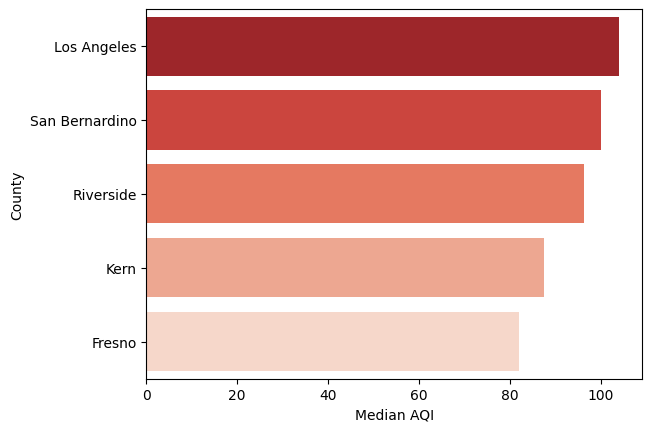

In [18]:
ca_medianaqi_by_county = ca_aqi.groupby('County')[['Median AQI']].mean(numeric_only=True).reset_index()
worst_ca_counties = ca_medianaqi_by_county.sort_values(by='Median AQI', ascending=False)

sns.barplot(data=worst_ca_counties.head(5), x="Median AQI", y="County", hue="County", palette="Reds_r", legend=False)

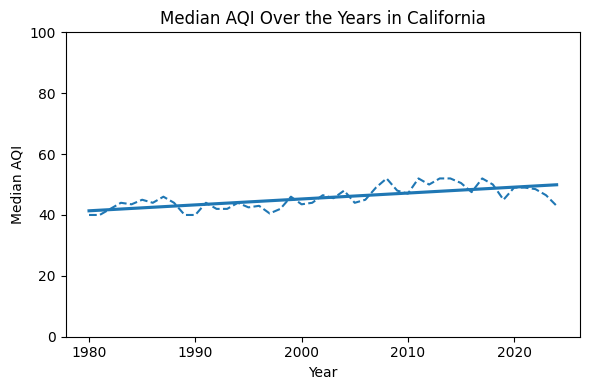

In [34]:
ca_aqi_byyear = ca_aqi.groupby('Year').median(numeric_only=True).reset_index()

plt.figure(figsize=(6, 4))
plt.plot(ca_aqi_byyear['Year'], ca_aqi_byyear['Median AQI'], label='Median AQI', linestyle='--', color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765))
sns.regplot(data=ca_aqi_byyear, x='Year', y='Median AQI', scatter=None, ci=None, color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765))

plt.title('Median AQI Over the Years in California')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

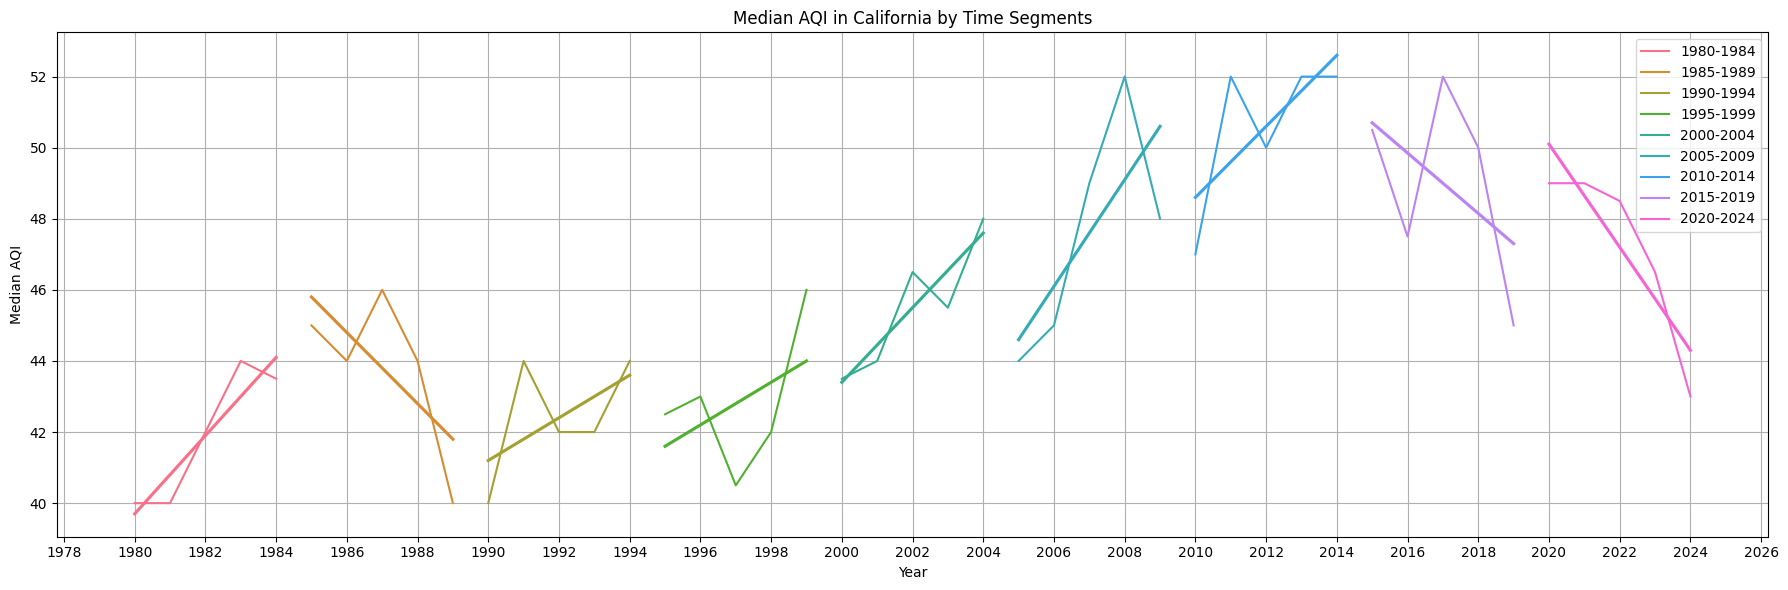

In [20]:
# Define segments
segments = [
    (1980, 1984),
    (1985, 1989),
    (1990, 1994),
    (1995, 1999),
    (2000, 2004),
    (2005, 2009),
    (2010, 2014),
    (2015, 2019),
    (2020, 2024)
]

# Plotting
plt.figure(figsize=(18, 6))
palette = sns.color_palette("husl", len(segments))

for i, (start, end) in enumerate(segments):
    segment_df = ca_aqi_byyear[(ca_aqi_byyear['Year'] >= start) & (ca_aqi_byyear['Year'] <= end)]
    plt.plot(segment_df['Year'], segment_df['Median AQI'], label=f'{start}-{end}', color=palette[i])
    sns.regplot(data=segment_df, x='Year', y='Median AQI', scatter=False, ci=None, color=palette[i])

plt.title('Median AQI in California by Time Segments')
plt.xlabel('Year')
plt.ylabel('Median AQI')
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LA

In [21]:
LA_aqi = ca_aqi[ca_aqi['County'] == 'Los Angeles']
LA_aqi = LA_aqi.sort_values(by='Year', ascending=True).reset_index(drop=True).copy()
LA_aqi.head(5)

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,State Abbrev,Balanced Max AQI
0,California,Los Angeles,1980,366,6,73,81,47,156,3,386,278,168,77,90,199,0,0,CA,386
1,California,Los Angeles,1981,365,4,56,99,46,160,0,300,268,176,71,92,202,0,0,CA,300
2,California,Los Angeles,1982,365,8,83,91,54,129,0,300,265,151,63,126,176,0,0,CA,300
3,California,Los Angeles,1983,365,11,103,79,37,135,0,300,280,143,61,126,178,0,0,CA,300
4,California,Los Angeles,1984,366,5,71,101,52,137,0,300,263,154,70,87,209,0,0,CA,300


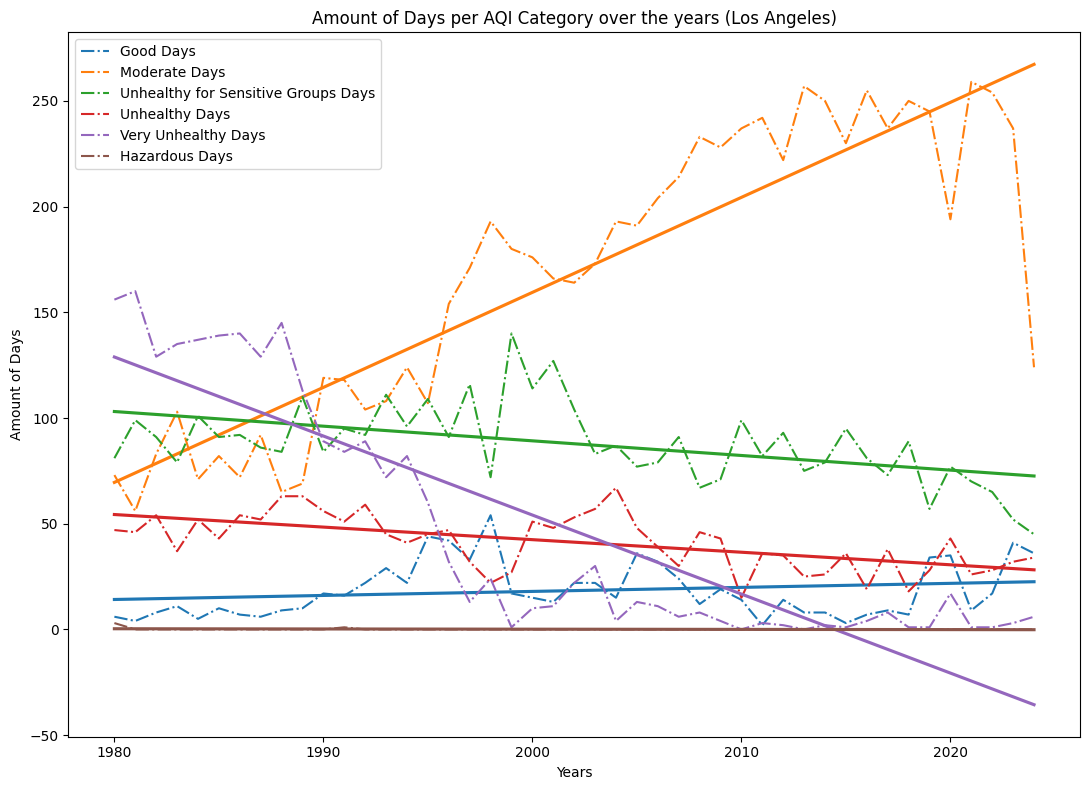

In [22]:
days = ['Good Days', 'Moderate Days', 'Unhealthy for Sensitive Groups Days',
        'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days']

palette = sns.color_palette("tab10", n_colors=len(days))
color_dict = dict(zip(days, palette))

plt.figure(figsize=(11, 8))

for col in days:
    color = color_dict[col]
    plt.plot(LA_aqi['Year'], LA_aqi[col], label=col, color=color, linestyle='dashdot')
    sns.regplot(data=LA_aqi, x='Year', y=col, scatter=False, ci=None, color=color)

plt.title('Amount of Days per AQI Category over the years (Los Angeles)')
plt.xlabel('Years')
plt.ylabel('Amount of Days')
plt.legend()
plt.tight_layout()
plt.show()

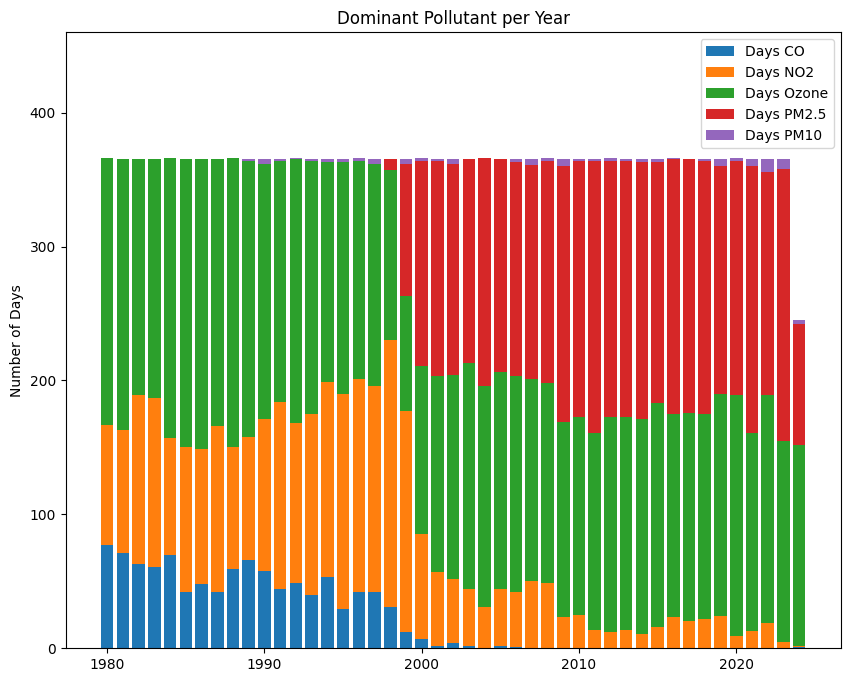

In [23]:
pollutant_days = ['Days CO', 'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10']

plt.figure(figsize=(10, 8))

plt.bar(LA_aqi['Year'], LA_aqi['Days CO'], label='Days CO')
plt.bar(LA_aqi['Year'], LA_aqi['Days NO2'], bottom=LA_aqi['Days CO'], label='Days NO2')
plt.bar(LA_aqi['Year'], LA_aqi['Days Ozone'], bottom=(LA_aqi['Days CO']+LA_aqi['Days NO2']), label='Days Ozone')
plt.bar(LA_aqi['Year'], LA_aqi['Days PM2.5'], bottom=(LA_aqi['Days CO']+LA_aqi['Days NO2']+LA_aqi['Days Ozone']), label='Days PM2.5')
plt.bar(LA_aqi['Year'], LA_aqi['Days PM10'], bottom=(LA_aqi['Days CO']+LA_aqi['Days NO2']+LA_aqi['Days Ozone']+LA_aqi['Days PM2.5']), label='Days PM10')

plt.ylabel('Number of Days')
plt.title('Dominant Pollutant per Year')
plt.legend()
plt.ylim(0, 460)  # Define o limite superior do eixo y
plt.show()

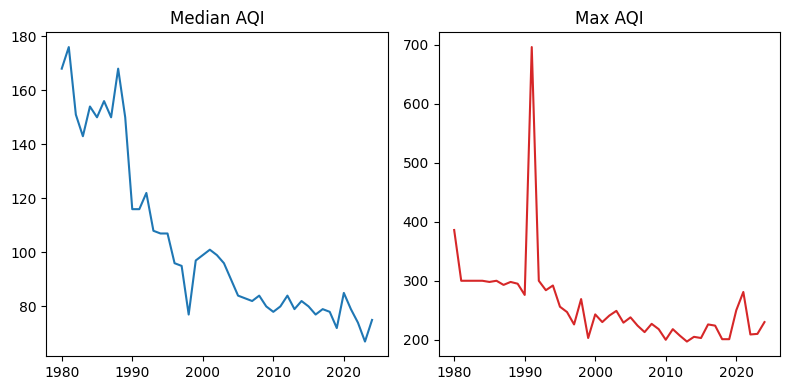

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True)

axs[0].plot(LA_aqi['Year'], LA_aqi['Median AQI'], label='Median AQI', color='tab:blue')
axs[0].set_title('Median AQI')

axs[1].plot(LA_aqi['Year'], LA_aqi['Max AQI'], label='Max AQI', color='tab:red')
axs[1].set_title('Max AQI')

plt.tight_layout()
plt.show()


In [25]:
ca_aqi.sort_values(by='Year').reset_index(drop=True)

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,State Abbrev,Balanced Max AQI
0,California,Marin,1980,366,284,70,12,0,0,0,115,68,38,31,257,78,0,0,CA,115
1,California,Mendocino,1980,353,347,6,0,0,0,0,67,42,28,0,0,353,0,0,CA,67
2,California,Mono,1980,205,172,33,0,0,0,0,91,56,24,205,0,0,0,0,CA,91
3,California,Monterey,1980,366,318,40,5,2,1,0,203,57,37,2,114,250,0,0,CA,203
4,California,Santa Barbara,1980,366,136,178,43,7,2,0,213,108,61,37,79,250,0,0,CA,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,California,Imperial,2024,192,65,107,20,0,0,0,136,101,56,0,1,113,53,25,CA,136
2307,California,Shasta,2024,211,178,32,1,0,0,0,108,54,43,0,0,184,18,9,CA,108
2308,California,Siskiyou,2024,17,17,0,0,0,0,0,11,9,3,0,0,0,17,0,CA,11
2309,California,Solano,2024,274,255,19,0,0,0,0,80,48,37,0,2,250,22,0,CA,80


In [26]:
ca_aqi['County'].nunique()

58

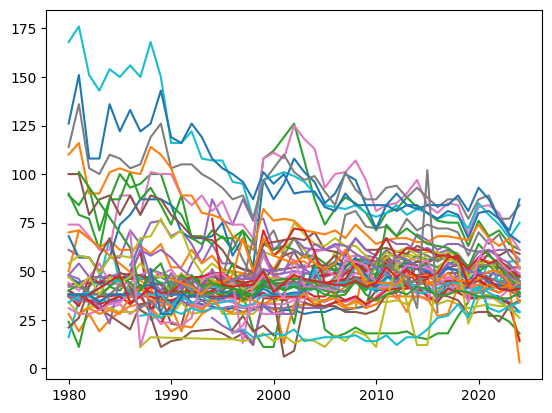

In [27]:
ca_aqi = ca_aqi.sort_values(by='Year').reset_index(drop=True)

for county in ca_aqi['County'].unique():
    plt.plot(ca_aqi[ca_aqi['County']==county]['Year'], ca_aqi[ca_aqi['County']==county]['Median AQI'], label=county)